# Download COVID-19 data from Kaggle
source: https://www.kaggle.com/c/covid19-global-forecasting-week-5/data?select=train.csv

In this tutorial, data and models will be load and save to google drive to prevent data loss when colab disconnect.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%cd /content/drive/My\ Drive/covid_19_forecast

/content/drive/My Drive/covid_19_forecast


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ModelCheckpoint
import time
import datetime

# Data Preprocessing

In [3]:
# Load data from wherever you put it.
data = pd.read_csv('covid19-global-forecasting-week-5/train.csv')
data

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
851893,969602,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-22,Fatalities,0.0
851894,969603,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-23,ConfirmedCases,5.0
851895,969604,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-23,Fatalities,0.0
851896,969605,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-24,ConfirmedCases,0.0


In [0]:
def negative_to_zero(row):
  '''
  For each row, returns 0 if TargetValue is negative otherwise returns original value since the number of new confirmed cases cannot be less than zero.
  '''
  
  if row['TargetValue'] < 0:
    return 0
  else:
    return row['TargetValue']

In [0]:
def preprocess_data(data_df, window_size=30, split_time=100, seed=0):
  '''
  Convert data into trainable format.
    1. Consider only country-level data of "ConfirmCases".
    2. For each country, normalize the values by subtracting the mean and dividing by the standard deviation.
    3. Split into windows.
    4. Split windows into train and test set. 
      4.1 Store test data of each country in a dict.
      4.2 Shuffle (every country) the train set to avoid "Sequence Bias" .
    5. For each window, use the last entry as y and the the rest as x.

  Arguments:
    data_df - dataframe of a raw data.
    window_size - number of timesteps to include for making 1 prediction. Ex. window_size=30 >> previous 30 datapoints are used to predict the next datapoint.
    split_time -  timestep to split windows into train and test windows (sets).
    seed - for reproducibility of randomization when shuffling the train set.

  Reutrns:
    x_train_case - feature(s) of train set.
    y_train_case - targets of train set.
    test_dict - a dictionary containing feature(s) and target of test set as well as the mean and the standard deviation of the number of confirmed cases for each country.
    x_test_case - feature(s) of test set of all countries.
    y_test_case - targets of test set of all countries.
  '''

  # Use country-level data of "ConfirmCases" only
  data_df = data_df[data_df.Province_State.isnull()]
  train_case = []
  y_train_case = []
  test_case = []
  test_dict = {}

  # Impute negative values to zeroes
  data_df['TargetValue_0'] = data_df.apply(lambda row: negative_to_zero(row), axis=1)

  # Insert data by country
  for country in data_df.Country_Region.unique():

    # Normalization by country >> (x - mean) / sd
    df_case = data_df[ (data_df.Country_Region==country) & (data_df.Target=='ConfirmedCases') ]
    df_case['NormTarget'] = (df_case['TargetValue_0']-np.mean(df_case['TargetValue_0'])) / np.std(df_case['TargetValue_0'])

    # Split data into windows
    case = []
    for i in range(len(df_case)-window_size):
      try:
        case.append(df_case.values[i:window_size+i+1, (4,8,10)]) # [#timestep(window_size), features(#population,#case,normalized #case)]
      except:
        case.append(df_case.values[i:, (4,8,10)])
    case = np.array(case)

    # Create train data
    train_case.append(case[:split_time-window_size])

    # Create test data
    test_case.append(case[split_time-window_size:])

    # Create test data of each country's normalized # of confirmed cases. Store in test_dict
    test = []
    test.append(case[split_time-window_size:])
    test = np.array(test)
    test = test.reshape(-1, test.shape[2], test.shape[3])
    test_dict[country+'_x'] = test[:,:-1,-1:].astype('float32')
    test_dict[country+'_y'] = test[:,-1:,-1:].astype('float32')
    test_dict[country+'_mean'] = np.mean(df_case['TargetValue_0'])
    test_dict[country+'_sd'] = np.std(df_case['TargetValue_0'])

  # Convert to numpy array and flatten the first 2 axes
  train_case = np.array(train_case)
  train_case = train_case.reshape(-1, train_case.shape[2], train_case.shape[3])
  test_case = np.array(test_case)
  test_case = test_case.reshape(-1, test_case.shape[2], test_case.shape[3])

  # Shuffle only the train data
  np.random.seed(seed) # for reproducibility
  np.random.shuffle(train_case)

  # Separate into x and y (separate the last entry of each to be y and use only the #case)
  x_train_case = train_case[:,:-1,-1:]
  y_train_case = train_case[:,-1:,-1:]
  x_test_case = test_case[:,:-1,-1:]
  y_test_case = test_case[:,-1:,-1:]

  # Print shapes for sanity check
  print('x_train shape:', x_train_case.shape) # 70 rows for each country
  print('y_train shape:', y_train_case.shape) # 23 rows for each country
  print('x_test shape (all):', x_test_case.shape)
  print('y_test shape (all):', y_test_case.shape)
  print('x_test shape (US):', test_dict['US_x'].shape)
  print('y_test shape (US):', test_dict['US_y'].shape)

  return x_train_case.astype('float32'), y_train_case.astype('float32'), x_test_case.astype('float32'), y_test_case.astype('float32'), test_dict, data_df

In [6]:
x_train_case, y_train_case, x_test_case, y_test_case, test_dict, data_df = preprocess_data(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


x_train shape: (13090, 30, 1)
y_train shape: (13090, 1, 1)
x_test shape (all): (4301, 30, 1)
y_test shape (all): (4301, 1, 1)
x_test shape (US): (23, 30, 1)
y_test shape (US): (23, 1, 1)


# Model

## Trial run to get the optimal learning rate

If all these requirements are met, CuDNN will be used autimatically:
- activation == tanh
- recurrent_activation == sigmoid
- recurrent_dropout == 0
- unroll is False
- use_bias is True
- Inputs are not masked or strictly right padded.
(These are all default settings of LSTM)

In [0]:
def optimal_lr(x_train_case, y_train_case):
  # Trial run to get the optimal learning rate
  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  np.random.seed(51)

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="same", # padding='causal' is causal convolution with padding='same'
                        activation="relu",
                        input_shape=(x_train_case.shape[1:])), #[None,2]), # None=can take sequence of any length, 1=series dim (univariate)
    
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x) # *400 b/c the actual values of sunspot are usually large (hundreds)
  ])                                          # but the predicted values are usually 0-1 (as a result of relu activation), so multiply by 400

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to noisy data
                optimizer=optimizer,
                metrics=["mae"])
  history = model.fit(x_train_case, y_train_case, batch_size=256, epochs=200, callbacks=[lr_schedule])
  
  # Plot to see optimal learning rate
  plt.semilogx(history.history["lr"], history.history["loss"])

  return history

Epoch 1/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4697 - mae: 0.7970 - lr: 1.0000e-08
Epoch 2/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4688 - mae: 0.7956 - lr: 1.1220e-08
Epoch 3/200
52/52 [==============================] - 2s 33ms/step - loss: 0.4634 - mae: 0.7878 - lr: 1.2589e-08
Epoch 4/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4649 - mae: 0.7892 - lr: 1.4125e-08
Epoch 5/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4654 - mae: 0.7892 - lr: 1.5849e-08
Epoch 6/200
52/52 [==============================] - 2s 33ms/step - loss: 0.4628 - mae: 0.7868 - lr: 1.7783e-08
Epoch 7/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4659 - mae: 0.7928 - lr: 1.9953e-08
Epoch 8/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4610 - mae: 0.7870 - lr: 2.2387e-08
Epoch 9/200
52/52 [==============================] - 2s 34ms/step - loss: 0.4628 - mae: 0.7869 - lr: 2.5

(1e-08, 10.0, 0.0, 1.0)

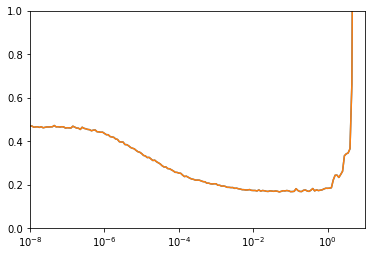

In [79]:
# Run it
history = optimal_lr(x_train_case, y_train_case)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 10, 0, 1])

Here the most optimal learning rate is around 0.1259

## Train

In [0]:
def convlstm(lr, best_model_only=False):
  # Trial run to get the optimal learning rate
  tf.keras.backend.clear_session()
  #tf.random.set_seed(51)
  #np.random.seed(51)

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="same", # padding='causal' is causal convolution with padding='same'
                        activation="relu",
                        input_shape=(x_train_case.shape[1:])), #[None,2]), # None=can take sequence of any length, 1=series dim (univariate)
    
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x) # *400 b/c the actual values of sunspot are usually large (hundreds)
  ])                                          # but the predicted values are usually 0-1 (as a result of relu activation), so multiply by 400

  # Compile the model
  optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to noisy data
                optimizer=optimizer,
                metrics=["mae"])

  # Log training and save only the best models
  if best_model_only:
    NAME = f"{int(time.time())}"  # a unique name for the model
    tensorboard = TensorBoard(log_dir=f"logs/{NAME}") #.format(NAME))
    filepath = "RNN_Final-{epoch:02d}-{val_mae:.3f}"  # unique file name that will include the epoch and the validation mae for that epoch
    if not os.path.exists('models'):
      os.mkdir('models')
    checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

  return model

Epoch 1/150
52/52 [==============================] - 2s 31ms/step - loss: 0.2289 - mae: 0.4879 - val_loss: 0.3925 - val_mae: 0.6664
Epoch 2/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1857 - mae: 0.4105 - val_loss: 0.3450 - val_mae: 0.6079
Epoch 3/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1761 - mae: 0.3893 - val_loss: 0.2948 - val_mae: 0.5605
Epoch 4/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1739 - mae: 0.3863 - val_loss: 0.2882 - val_mae: 0.5376
Epoch 5/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1710 - mae: 0.3793 - val_loss: 0.3007 - val_mae: 0.5588
Epoch 6/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1715 - mae: 0.3813 - val_loss: 0.3262 - val_mae: 0.5963
Epoch 7/150
52/52 [==============================] - 1s 12ms/step - loss: 0.1704 - mae: 0.3772 - val_loss: 0.2917 - val_mae: 0.5458
Epoch 8/150
52/52 [==============================] - 1s 12ms/step - loss: 0.

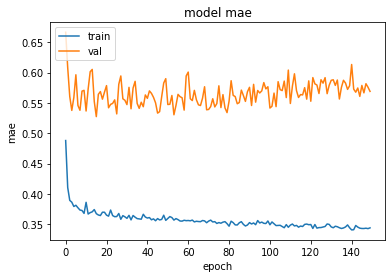

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/convlstm_150_3440_5689_2020-05-30-10-32-02/assets


In [8]:
# Train the model
model = convlstm(lr=0.1259)
history = model.fit(x_train_case, y_train_case, batch_size=256, epochs=150, validation_data=(x_test_case, y_test_case)) #, callbacks=[tensorboard, checkpoint])

# Plot training graph
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save the model without overwriting the old ones
if not os.path.exists('models'):
  os.mkdir('models')

epoch = len(history.history['val_mae'])
train_mae = history.history['mae'][-1]*10000
val_mae = history.history['val_mae'][-1]*10000
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
model_path = f'models/convlstm_{epoch}_{train_mae:.0f}_{val_mae:.0f}_{dt}'
model.save(model_path)

From the graph, you can see that the model is clearly overfitting >> further model tuning, namedly regularization and etc., and/or data collecting is required.

## Make prediction

In [0]:
# Load model
model = tf.keras.models.load_model(model_path)
print(model_path)

In [0]:
def plot_series(series_a, series_b, format="-"): # format could be '.' and 'o' for different plot style
    plt.plot(series_a, format)
    plt.plot(series_b, format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
def model_forecast_by_country(model, test_dict, country):
  '''
  Make predictions and plot them against actual target by country.

  Arguments:
    model - the trained model.
    test_dict - a dictionary containing feature(s) and target of test set as well as the mean and the standard deviation of the number of confirmed cases for each country.
    country - country to be predicted.

  Returns:
    forecast - model's predictions
  '''

  # Make predictions
  forecast = model.predict(test_dict[country+'_x'])

  # Plot targets vs. predictions
  #plt.figure(figsize=(10, 8))
  y_raw = test_dict[country+'_y'].reshape(test_dict[country+'_y'].shape[0],-1)*test_dict[country+'_sd']+test_dict[country+'_mean'] # convert back to raw value (before normalization)
  forecast_raw = forecast*test_dict[country+'_sd']+test_dict[country+'_mean'] # convert back to raw value (before normalization)
  
  # Calculate MAE
  mae = np.mean(np.abs(y_raw - forecast_raw))
  print('MAE =', mae)

  # Calculate percentage error
  percent_abs_error = np.abs(y_raw - forecast_raw)/np.abs(y_raw)

  error = np.mean(np.abs(y_raw - forecast_raw)/np.abs(y_raw))
  print('Error =', error*100, '%')

  plot_series(y_raw, forecast_raw)
  plt.title(country)
  plt.ylabel('# of confirmed cases')
  plt.xlabel('date')
  plt.legend(['actual', 'prediction'], loc='upper left')
  plt.show()

  return forecast, np.abs(y_raw - forecast_raw)/np.abs(y_raw)

In [0]:
def model_forecast(model, x_test_case, y_test_case):
  '''
  Make predictions and plot them over all datapoints.

  Arguments:
    model - the trained model.
    x_test_case - feature(s) of test set.
    y_test_case - target of test set.

  Returns:
    forecast - model's predictions
  '''

  forecast = model.predict(x_test_case)
    
  # Calculate MAE
  mae = np.mean(np.abs(y_test_case - forecast))
  print('MAE =', mae)

  # Calculate percentage error
  error = np.mean(np.abs(y_test_case - forecast)/np.abs(y_test_case))
  print('Error =', error*100, '%')

  plot_series(y_test_case.reshape(y_test_case.shape[0],-1), forecast)
  plt.title('ALL country')
  plt.ylabel('# of confirmed cases')
  plt.xlabel('date')
  plt.legend(['actual', 'prediction'], loc='upper left')
  plt.show()

  return forecast

MAE = 0.97518575
Error = 218.6948537826538  percent


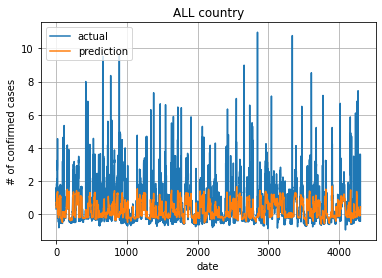

In [184]:
forecast_all = model_forecast(model, x_test_case, y_test_case)

MAE = 716.00885
Error = 7.072295993566513 %


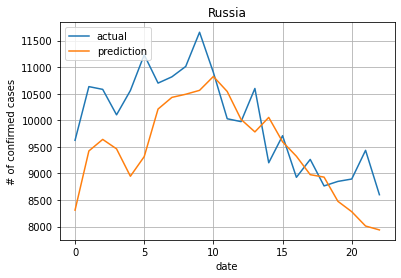

In [86]:
forecast_us = model_forecast_by_country(model, test_dict, 'Russia')

MAE = 195.02795
Error = 22.05539345741272 %


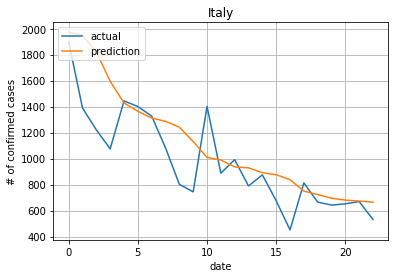

In [21]:
forecast_us = model_forecast_by_country(model, test_dict, 'Italy')

MAE = 2044.9053
Error = 9.433532506227493 %


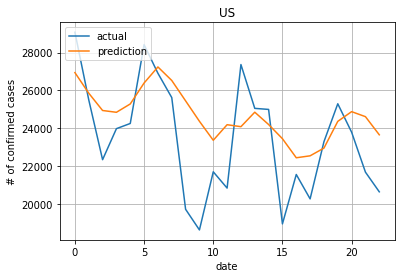

In [32]:
forecast_us = model_forecast_by_country(model, test_dict, 'US')

MAE = 3.2023714
Error = inf %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


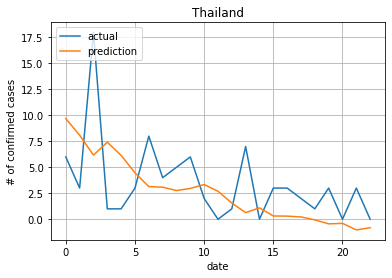

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


In [14]:
forecast_thailand, nn = model_forecast_by_country(model, test_dict, 'Thailand')

MAE = 663.00494
Error = 54153893.75 %


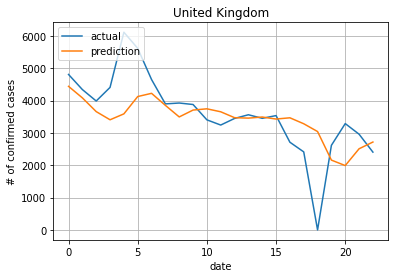

In [22]:
forecast_thailand, nn = model_forecast_by_country(model, test_dict, 'United Kingdom')

# Old Results

MAE = 2158.814
Error = 9.889817982912064  percent


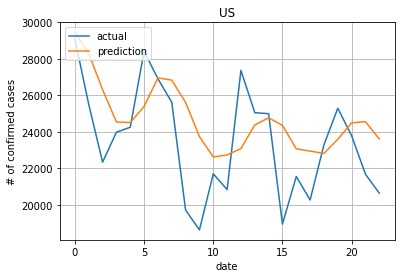

In [107]:
forecast_200_same = model_forecast_by_country(model, test_dict, 'US')

MAE = 2740.4338
Error = 27.161318063735962  percent


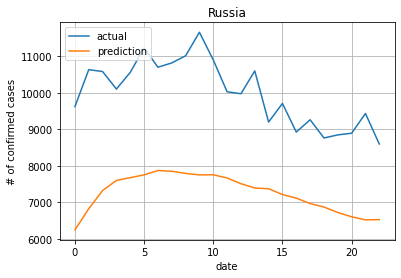

In [180]:
forecast_200_same = model_forecast_by_country(model, test_dict, 'Russia')

MAE = 1158.0945
Error = 11.504705995321274  percent


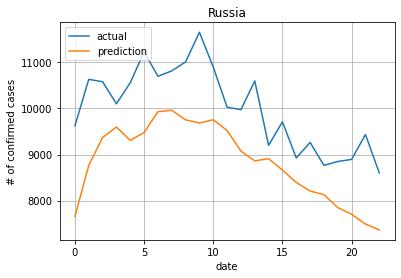

In [108]:
forecast_200_same = model_forecast(model, test_dict, 'Russia')

MAE = 3310.9277
Error = 26.120883226394653  percent


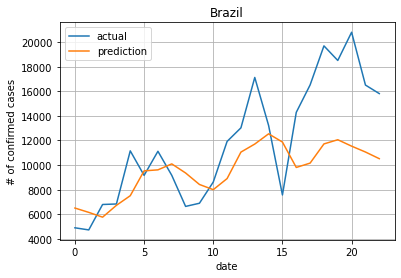

In [97]:
forecast_200_same = model_forecast(model, test_dict, 'Brazil')

MAE = 699.3794
Error = -14.876267313957214  percent


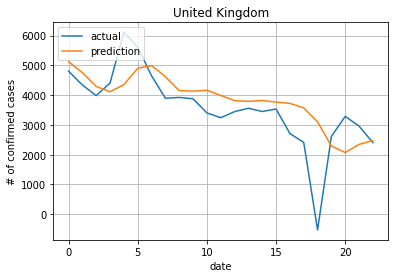

In [98]:
forecast_200_same = model_forecast(model, test_dict, 'United Kingdom')

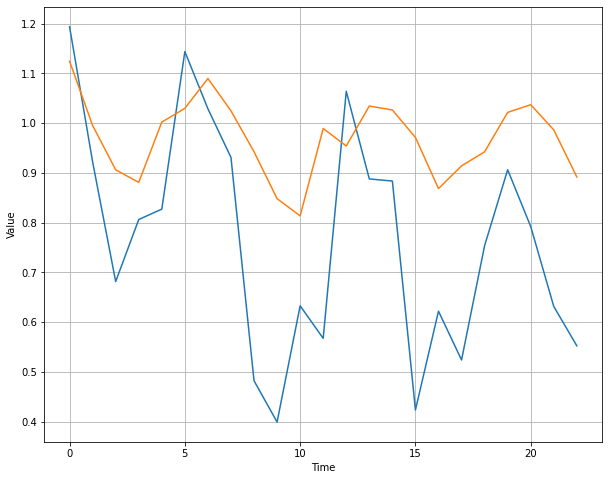

In [20]:
forecast_200_causal = model_forecast(model, test_dict['US_x'], test_dict['US_y'])

In [0]:
forecast = model.predict(test_x.astype('float32'))

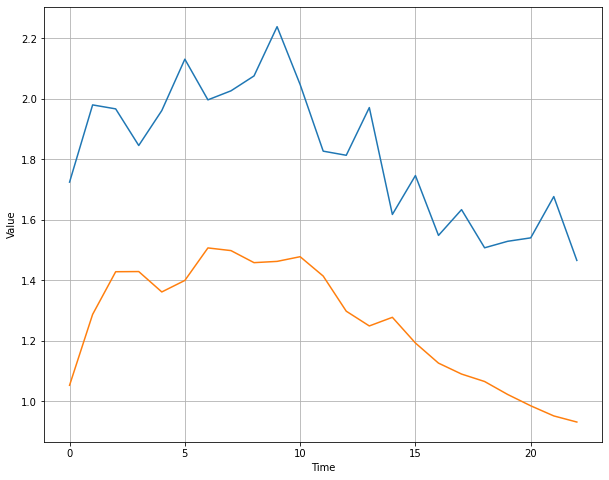

In [29]:
# 100 epoch
plt.figure(figsize=(10, 8))
plot_series(test_y.reshape(test_y.shape[0],-1), forecast)

#plt.axis([0, 23, 0, 0.0003])

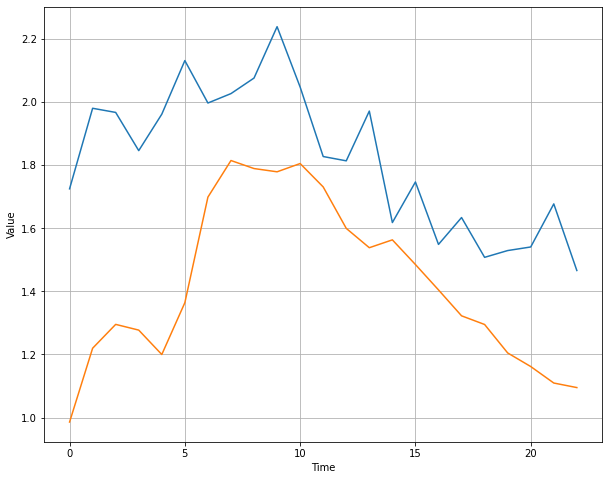

In [31]:
forecast2 = model.predict(test_x.astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(test_y.reshape(test_y.shape[0],-1), forecast2)

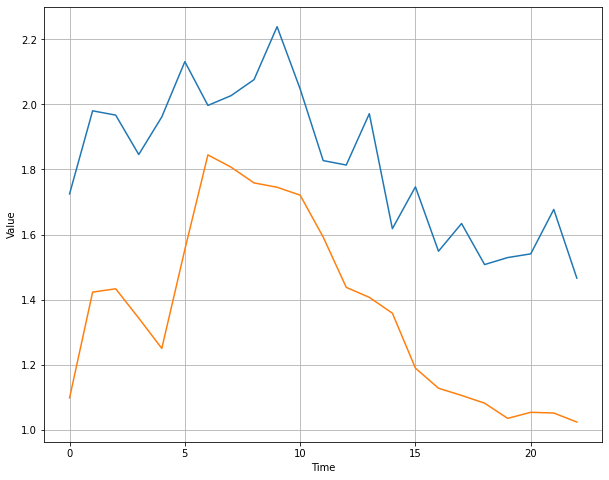

In [33]:
forecast3 = model.predict(test_x.astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(test_y.reshape(test_y.shape[0],-1), forecast3)

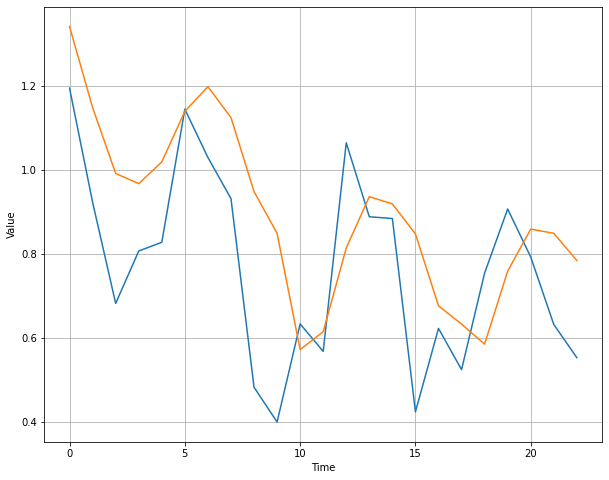

In [41]:
forecast300 = model.predict(test_dict['US_x'].astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(test_dict['US_y'].reshape(test_dict['US_y'].shape[0],-1), forecast300)

In [105]:
(np.abs(1.33-1.2)+np.abs(1-.7)+np.abs(.98-.81)+np.abs(1.15-.82)+np.abs(1.2-1.04)+np.abs(1.17-1.167)+np.abs(1.2-1.05)+np.abs(.951-.13)+np.abs(.58-.62)+np.abs(.58-.61)+np.abs(.81-1.07)+np.abs(.06)+np.abs(.04)+np.abs(.42-.85)+np.abs(0.06)+np.abs(.09)+np.abs(.17)+np.abs(.18)+np.abs(.05)+np.abs(.22) )/ 20

0.18469999999999998

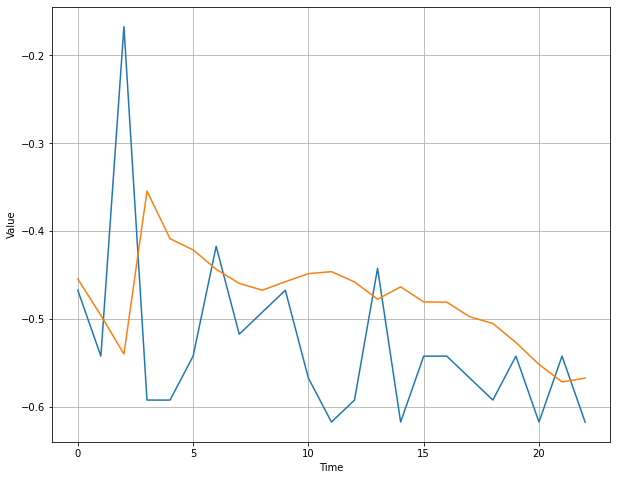

In [42]:
forecast300 = model.predict(test_dict['Thailand_x'].astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(test_dict['Thailand_y'].reshape(test_dict['Thailand_y'].shape[0],-1), forecast300)

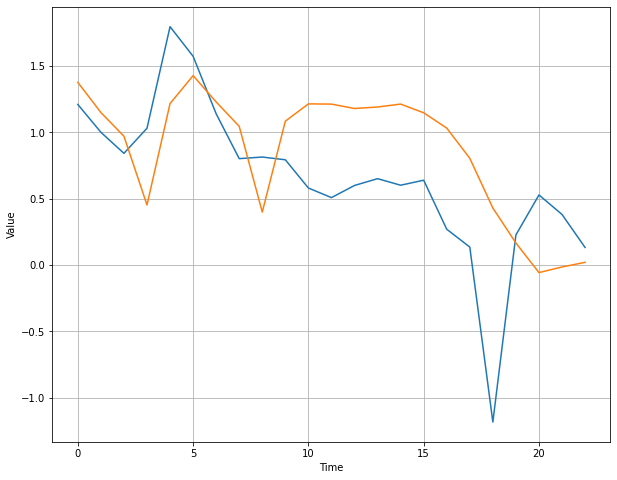

In [44]:
forecast300 = model.predict(test_dict['United Kingdom_x'].astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(test_dict['United Kingdom_y'].reshape(test_dict['United Kingdom_y'].shape[0],-1), forecast300)

In [47]:
y_test_case.shape

(4301, 1, 1)

(0.0, 4311.0, -2.5, 7.5)

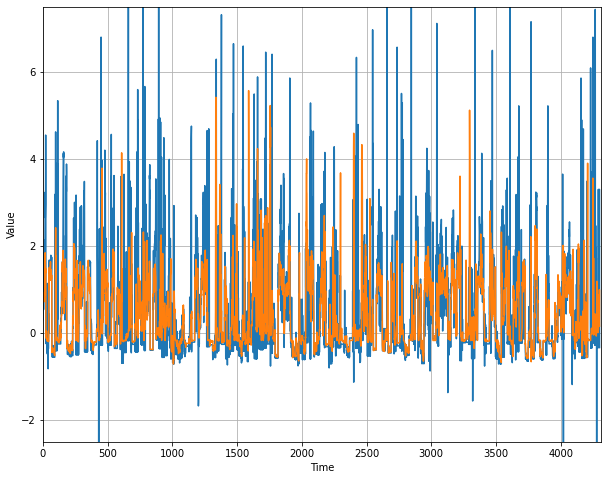

In [50]:
forecast300 = model.predict(x_test_case.astype('float32'))
plt.figure(figsize=(10, 8))
plot_series(y_test_case.reshape(y_test_case.shape[0],-1), forecast300)
plt.axis([0, y_test_case.shape[0]+10, -2.5, 7.5])

# Resources

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

# Add to tf.keras callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard — logdir logs

In [0]:
def preprocess_data(data_df, window_size=30, split_time=100, seed=0):
  data_df = data_df[data_df.Province_State.isnull()]
  data_df['NormTarget'] = (data_df['TargetValue'] - np.mean(data_df['TargetValue']))/np.std(data_df['TargetValue']) #data_df.apply(lambda row: norm(row), axis=1)#data_df['TargetValue'] #data_df['TargetValue'] / data_df['Population']

  train_case = []
  y_train_case = []
  test_case = []
  y_test_case = []
  test = []

  x_fatal = []
  y_fatal = []

  for country in data_df.Country_Region.unique(): # ['US',"Russia","Thailand"]:

    # Confirmed Cases
    df_case = data_df[ (data_df.Country_Region==country) & (data_df.Target=='ConfirmedCases') ]

    case = []
    for i in range(len(df_case)-window_size):
      try:
        case.append(df_case.values[i:window_size+i+1, (4,8,9)]) # [#timestep(window_size), features(#population,#case)]
      except:
        case.append(df_case.values[i:, (4,8,9)])

    case = np.array(case)

    train_case.append(case[:split_time-window_size])
    #y_train_case.append(y_case[:split_time-window_size])
    test_case.append(case[split_time-window_size:])
    #y_test_case.append(y_case[split_time-window_size:])

    # Make a proper test case
    if country == 'Russia':
      test.append(case[split_time-window_size:])

    # # Fatalities
    # df_fatal = data_df[ (data_df.Country_Region==country) & (data_df.Target=='Fatalities') ]
    # if len(df_fatal) == 123:
    #   train_fatal.append(df_fatal.values[:,(4,8)][:-1])  # x = [#population, #fatal][:-1]
    #   test_fatal.append(df_fatal.values[:,8][-1:]) # y = [#case][-1:]. Must have ":" to retain the dimension
    # else:
    #   print('Skipped fatalities of', country)  

  # Convert to numpy array and flatten the first 2 axes
  train_case = np.array(train_case)
  train_case = train_case.reshape(-1, train_case.shape[2], train_case.shape[3])
  #x_train_case = x_train_case.reshape(-1, x_train_case.shape[2], x_train_case.shape[3])
  #y_train_case = np.array(y_train_case)
  #y_train_case = y_train_case.reshape(-1, y_train_case.shape[2], y_train_case.shape[3])

  test_case = np.array(test_case)
  test_case = test_case.reshape(-1, test_case.shape[2], test_case.shape[3])
  
  test = np.array(test)
  test = test.reshape(-1, test.shape[2], test.shape[3])
  # x_test_case = x_test_case.reshape(-1, x_test_case.shape[2], x_test_case.shape[3])
  # y_test_case = np.array(y_test_case)
  # y_test_case = y_test_case.reshape(-1, y_test_case.shape[2], y_test_case.shape[3])

  # Shuffle only the train data
  np.random.seed(seed) # to make it reproducible
  np.random.shuffle(train_case)

  # Separate into x and y (separate the last entry of each to be y and use only the #case)
  x_train_case = train_case[:,:-1,-1:]
  y_train_case = train_case[:,-1:,-1:]
  x_test_case = test_case[:,:-1,-1:]
  y_test_case = test_case[:,-1:,-1:]

  test_x = test[:,:-1,-1:]
  test_y = test[:,-1:,-1:]

  # Print shapes
  print('x_train shape:', x_train_case.shape) # 70 rows for each country
  print('y_train shape:', y_train_case.shape) # 23 rows for each country
  print('x_test shape:', x_test_case.shape)
  print('y_test shape:', y_test_case.shape)
  print('test_x shape:', test_x.shape)
  print('test_y shape:', test_y.shape)

  return x_train_case, y_train_case, x_test_case, y_test_case, test_x, test_y, data_df

In [0]:
def log10(row):
  result = np.log10(row['TargetValue'])
  if result < 0: # when log10(0) give -inf >> make it 0
    result = 0
  return result

In [0]:
def preprocess_data(data_df, split_timestep=):
  data_df = data_df.copy()
  data_df = data_df[data_df.Province_State.isnull()]

  train_case = []
  x_train_case = []
  y_train_case = []
  test_case = []
  train_fatal = []
  test_fatal = []
  
  for country in data_df.Country_Region.unique(): # ['US',"Russia","Thailand"]:

    # Confirmed Cases
    df_case = data_df[ (data_df.Country_Region==country) & (data_df.Target=='ConfirmedCases') ]
    if len(df_case) == 123:
      x_train_case.append(df_case.values[:,(4,8)][:-1]) # x = [#population, #case][:-1]
      y_train_case.append(df_case.values[:,8][-1:]) # y = [#case][-1:]. Must have ":" to retain the dimension
    else:
      print('Skipped confirmed cases of', country)

    # Fatalities
    df_fatal = data_df[ (data_df.Country_Region==country) & (data_df.Target=='Fatalities') ]
    if len(df_fatal) == 123:
      train_fatal.append(df_fatal.values[:,(4,8)][:-1])  # x = [#population, #fatal][:-1]
      test_fatal.append(df_fatal.values[:,8][-1:]) # y = [#case][-1:]. Must have ":" to retain the dimension
    else:
      print('Skipped fatalities of', country)  

  train_case = np.array(train_case)
  test_case = np.array(test_case)[..., np.newaxis]
  train_fatal = np.array(train_fatal)
  test_fatal = np.array(test_fatal)[..., np.newaxis]

  return 

In [0]:
def preprocess_data(data_df, window_size=30, split_time=100):
  data_df = data_df[data_df.Province_State.isnull()]

  x_train_case = []
  y_train_case = []
  x_test_case = []
  y_test_case = []

  x_fatal = []
  y_fatal = []

  for country in data_df.Country_Region.unique(): # ['US',"Russia","Thailand"]:

    # Confirmed Cases
    df_case = data_df[ (data_df.Country_Region==country) & (data_df.Target=='ConfirmedCases') ]

    x_case = []
    y_case = []
    for i in range(len(df_case)-window_size):
      x_case.append(df_case.values[i:window_size+i, (4,8)]) # [#timestep(window_size), features(#population,#case)]
      y_case.append(df_case.values[window_size+i, 8]) # [#timestep(window_size), features(#population,#case)]

    x_case = np.array(x_case)
    y_case = np.array(y_case)[...,np.newaxis][..., np.newaxis]

    x_train_case.append(x_case[:split_time-window_size])
    y_train_case.append(y_case[:split_time-window_size])
    x_test_case.append(x_case[split_time-window_size:])
    y_test_case.append(y_case[split_time-window_size:])

    # # Fatalities
    # df_fatal = data_df[ (data_df.Country_Region==country) & (data_df.Target=='Fatalities') ]
    # if len(df_fatal) == 123:
    #   train_fatal.append(df_fatal.values[:,(4,8)][:-1])  # x = [#population, #fatal][:-1]
    #   test_fatal.append(df_fatal.values[:,8][-1:]) # y = [#case][-1:]. Must have ":" to retain the dimension
    # else:
    #   print('Skipped fatalities of', country)  

  # train_case = np.array(train_case)
  # test_case = np.array(test_case)[..., np.newaxis]
  # train_fatal = np.array(train_fatal)
  # test_fatal = np.array(test_fatal)[..., np.newaxis]

  # Convert to numpy array and flatten the first 2 axes
  x_train_case = np.array(x_train_case)
  x_train_case = x_train_case.reshape(-1, x_train_case.shape[2], x_train_case.shape[3])
  y_train_case = np.array(y_train_case)
  y_train_case = y_train_case.reshape(-1, y_train_case.shape[2], y_train_case.shape[3])

  x_test_case = np.array(x_test_case)
  x_test_case = x_test_case.reshape(-1, x_test_case.shape[2], x_test_case.shape[3])
  y_test_case = np.array(y_test_case)
  y_test_case = y_test_case.reshape(-1, y_test_case.shape[2], y_test_case.shape[3])

  return x_train_case, y_train_case, x_test_case, y_test_case

### For plotting

In [0]:
def create_df(data_df, country):
  '''
  Creates dataframe of differnt countries.

  Arguments:
  data_df - the whole data in form of pandas dataframe.
  country - name of a country of interest.

  Returns:
  case - dataframe of confirmed cases.
  death - dataframe of fatalities.
  '''

  df = data_df[(data_df.Country_Region==country) & (data_df['Province_State'].isnull())]
  case = df[df.Target=='ConfirmedCases'].reset_index(drop=True)
  case.drop(['County', 'Province_State'], axis=1, inplace=True)
  death = df[df.Target=='Fatalities'].reset_index(drop=True)
  death.drop(['County', 'Province_State'], axis=1, inplace=True)

  return case, death

In [0]:
# Create data of different countries
us_case, us_death = create_df(data, 'US')
brazil_case, brazil_death = create_df(data, 'Brazil')
thailand_case, thailand_death = create_df(data, 'Thailand')
uk_case, uk_death =  create_df(data, 'United Kingdom')
france_case, france_death = create_df(data, 'France')
italy_case, italy_death = create_df(data, 'Italy')
russia_case, russia_death = create_df(data, 'Russia')
japan_case, japan_death = create_df(data, 'Japan')
korea_case, korea_death = create_df(data, 'South Korea')
china_case, china_death = create_df(data, 'China')

In [0]:
us_case

,Id,Country_Region,Population,Weight,Date,Target,TargetValue
0,962921,US,324141489,0.051029,2020-01-23,ConfirmedCases,0.0
1,962923,US,324141489,0.051029,2020-01-24,ConfirmedCases,0.0
2,962925,US,324141489,0.051029,2020-01-25,ConfirmedCases,0.0
3,962927,US,324141489,0.051029,2020-01-26,ConfirmedCases,0.0
4,962929,US,324141489,0.051029,2020-01-27,ConfirmedCases,0.0
...,...,...,...,...,...,...,...
118,963157,US,324141489,0.051029,2020-05-20,ConfirmedCases,23285.0
119,963159,US,324141489,0.051029,2020-05-21,ConfirmedCases,25293.0
120,963161,US,324141489,0.051029,2020-05-22,ConfirmedCases,23790.0
121,963163,US,324141489,0.051029,2020-05-23,ConfirmedCases,21675.0


In [0]:
us_death

,Id,Country_Region,Population,Weight,Date,Target,TargetValue
0,962922,US,324141489,0.51029,2020-01-23,Fatalities,0.0
1,962924,US,324141489,0.51029,2020-01-24,Fatalities,0.0
2,962926,US,324141489,0.51029,2020-01-25,Fatalities,0.0
3,962928,US,324141489,0.51029,2020-01-26,Fatalities,0.0
4,962930,US,324141489,0.51029,2020-01-27,Fatalities,0.0
...,...,...,...,...,...,...,...
118,963158,US,324141489,0.51029,2020-05-20,Fatalities,1518.0
119,963160,US,324141489,0.51029,2020-05-21,Fatalities,1263.0
120,963162,US,324141489,0.51029,2020-05-22,Fatalities,1277.0
121,963164,US,324141489,0.51029,2020-05-23,Fatalities,1108.0


In [0]:
# def plot_series(time, series, format="-", start=0, end=None): # format could be '.' and 'o' for different plot style
#     plt.plot(time[start:end], series[start:end], format)
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.grid(True)

In [0]:
def plot_series(series_a, series_b, format="-"): # format could be '.' and 'o' for different plot style
    plt.plot(series_a, format)
    plt.plot(series_b, format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

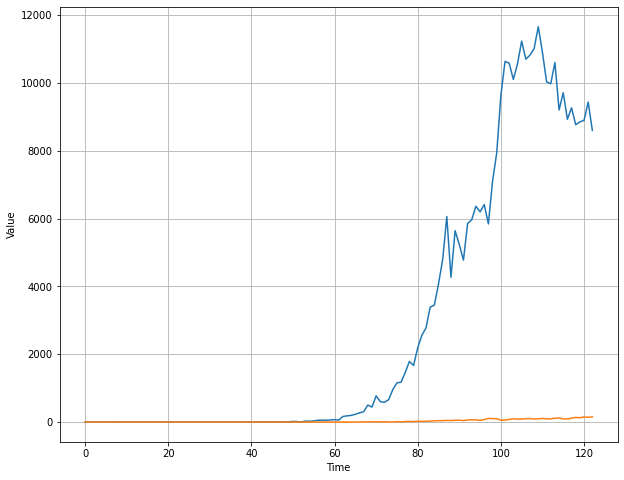

In [0]:
plt.figure(figsize=(10, 8))
plot_series(russia_case.TargetValue, russia_death.TargetValue)

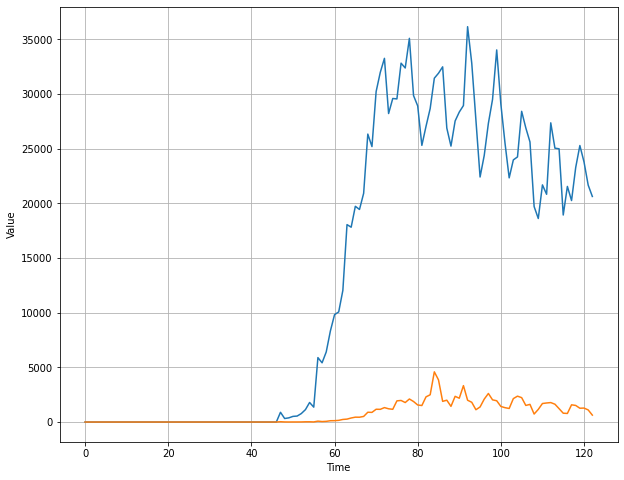

In [0]:
plt.figure(figsize=(10, 8))
plot_series(us_case.TargetValue, us_death.TargetValue)

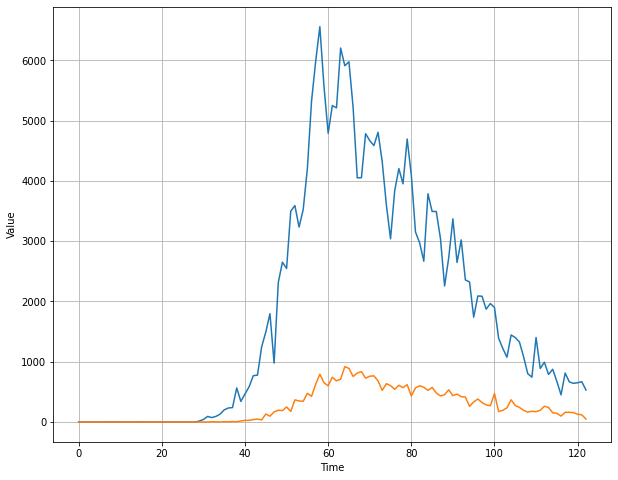

In [0]:
plt.figure(figsize=(10, 8))
plot_series(italy_case.TargetValue, italy_death.TargetValue)

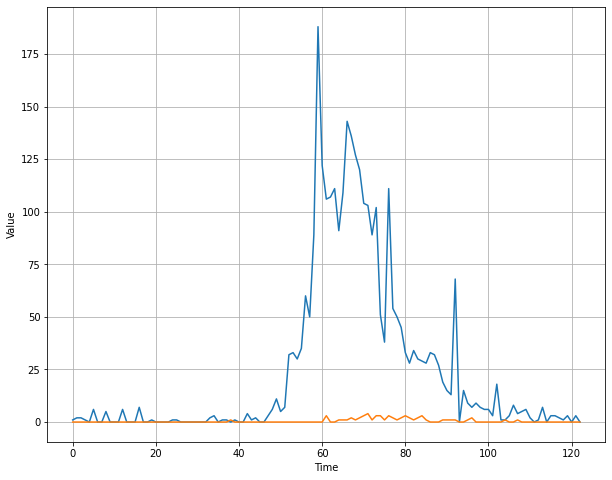

In [0]:
plt.figure(figsize=(10, 8))
plot_series(thailand_case.TargetValue, thailand_death.TargetValue)

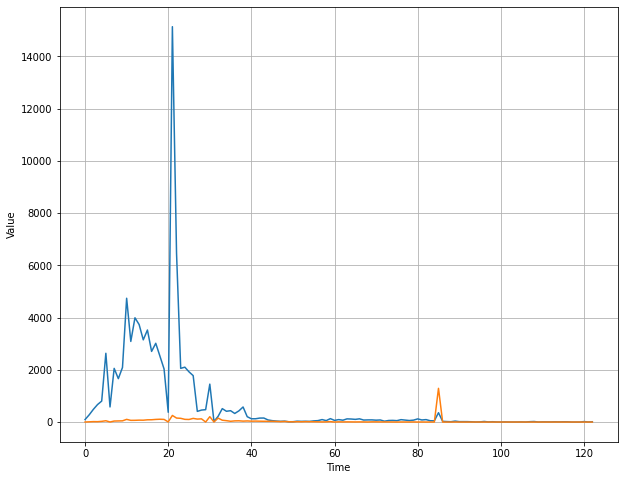

In [0]:
plt.figure(figsize=(10, 8))
plot_series(china_case.TargetValue, china_death.TargetValue)

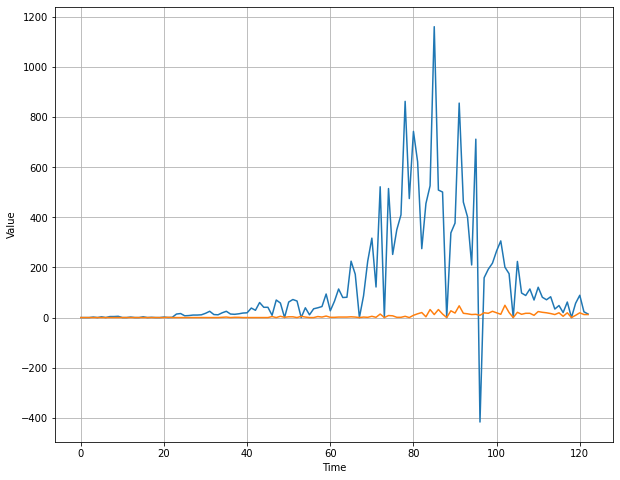

In [0]:
plt.figure(figsize=(10, 8))
plot_series(japan_case.TargetValue, japan_death.TargetValue)